본 튜토리얼은 Semi-Supervised Learning의 하위 분야 가운데 Hybrid/Holistic Method에 관련한 내용을 진행합니다.

선택한 모델은 제가 지난 pair study 과정에서 다룬 내용인 MixMatch, FixMatch, FlexMatch을 구현하겠습니다.


**<span style="color:blue">우선 각 모델별로 하이퍼파라미터 선정 혹은 증강 방법 결정에 따른 결과의 차이가 있는지 알아보고,</span>**

**<span style="color:blue">특히 MixMatch -> FixMatch -> FlexMatch의 순서로 논문이 나오고 또한 발전도 이루어진 것에 착안하여, 해당되는 부분에 있어서 결과적으로 어느정도의 차이가 있는지를 확인하는 것이 튜토리얼의 목적입니다.</span>**

## Import modules

In [1]:
import sys, os, copy, random, argparse, math
import numpy as np

import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets
from torchvision import transforms
from colorama import Fore
from tqdm import tqdm

# FlexMatch

FlexMatch는 FixMatch의 단점을 보완한 모델입니다. 지난 튜토리얼에서 FixMatch의 경우, 진행 과정중에서
    
    3. Unlabeled dataset에 대해 weak augmentation을 통과한 output에서, 가장 probability가 높은 값의 class를 pseudo-labeling 진행. (confidence threshold를 설정하여 해당 임계값을 넘지 못하면 탈락)
에 해당하는 해당 Class에 속할 확률값(SoftMax)이 일정 Threshold을 넘을 때 해당 Class에 속할 확률을 1로 pseudo-labeling하고, 만일 넘지 못한다면 그 샘플은 학습에 참여시키지 않는다는 부분이 있습니다.

이 과정에서 지난번에 생각한 추측(하단)에 대해서, FixMatch에서는 실험 설정의 miss로 인해 다른 결과가 나왔다고 생각하지만, 

**<span style="color:blue"> 높은 threshold를 설정하면, 성능은 유지하지만 제거되는 샘플이 제법 많이 늘어나게 되고, 자칫하면 샘플의 수가 충분하지 못한 상황이 생길 수 있는 단점이 생기고,</span>**

**<span style="color:blue"> 낮은 threshold를 설정하면 샘플의 수는 충분하지만 성능이 좋지 못한 결과를 초래할 수 있습니다.</span>**

**<span style="color:blue"> 이번 FlexMatch는 이름에서 느껴지는 것처럼 '유연하게' 임계치를 설정해서 '샘플의 부족'과 '임계치 설정을 통한 성능 유지'의 trade-off 관계를 유지하려고 합니다.</span>**

**<span style="color:blue"> 방법은 Class 별로 '분류의 난이도'에 따라 서로 다른 Threshold를 적용하는 방법을 도입합니다.</span>**

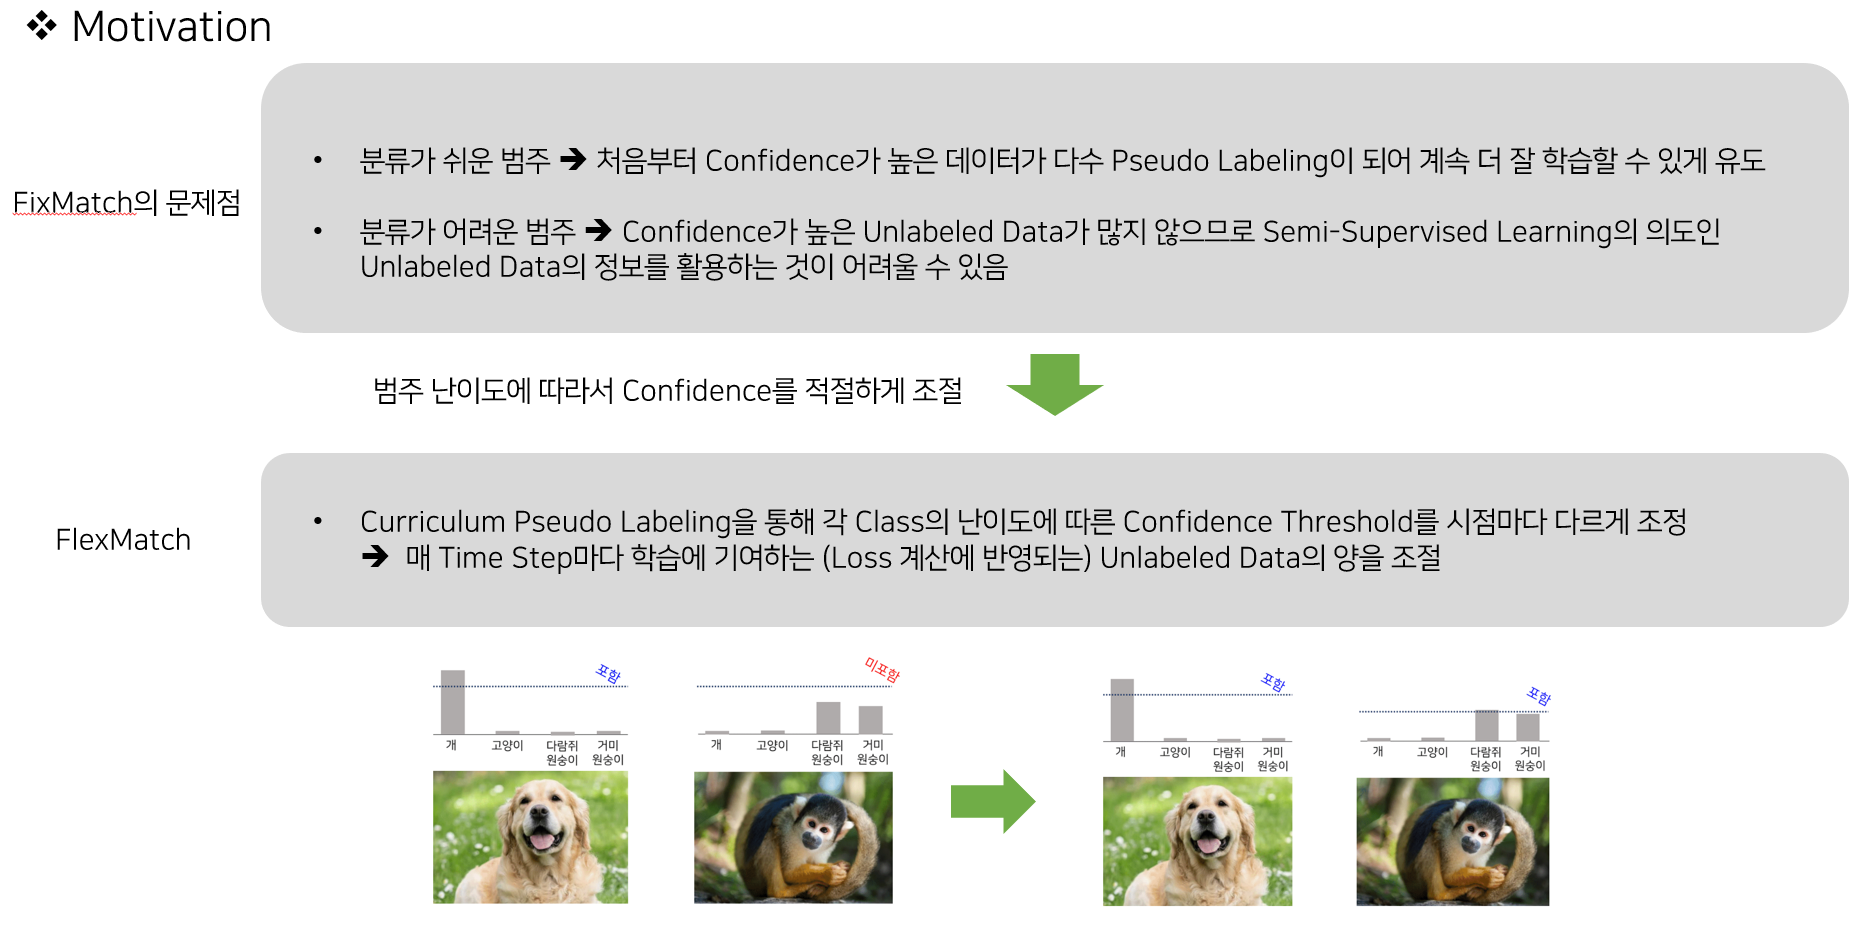

**<span style="color:blue"> 이번 튜토리얼에서는 FixMatch와 마찬가지로, </span>**

    3. Unlabeled dataset에 대해 weak augmentation을 통과한 output에서, 가장 probability가 높은 값의 class를 pseudo-labeling 진행. (confidence threshold를 설정하여 해당 임계값을 넘지 못하면 탈락)
**<span style="color:blue"> 에 대해서, 변화된 flexable confidence threshold를 도입하는 것이 과연 기본적인 confidence threshod의 고저에 따라서 어떠한 변화를 야기할지 확인해보겠습니다.</span>**

**<span style="color:blue"> 제 예상으로는 지난 FixMatch와는 다르게 기본 confidence threshold 설정의 변화에 대해 강건하게 Top 1 / Top 5 모두 좋은 결과가 나올 것 같다고 생각합니다.</span>**

# Load datasets

##### CIFAR10 : 이미지 분류에서 가장 많이 사용되는 데이터셋으로, 10개의 대분류 Class를 중심으로 각 Class별 6,000장의 이미지를 포함하고 있는 데이터셋.
##### 총 60,000장 가운데 Train:Test의 비율은 각 class별로 5:1로 되어있음

- 각 class별로 매우 상이한 차이가 있는 이미지 데이터셋이기 때문에 (e.g., ariplane V.S. frog),
- 가장 기본적인 이미지 분류 데이터셋으로 활용하고 있고, 조금 더 세밀하거나 더 다양한 범주와 더 많은 이미지 데이터 분류를 희망한다면 다른 데이터셋을 추가 사용하는 것을 추천드립니다.

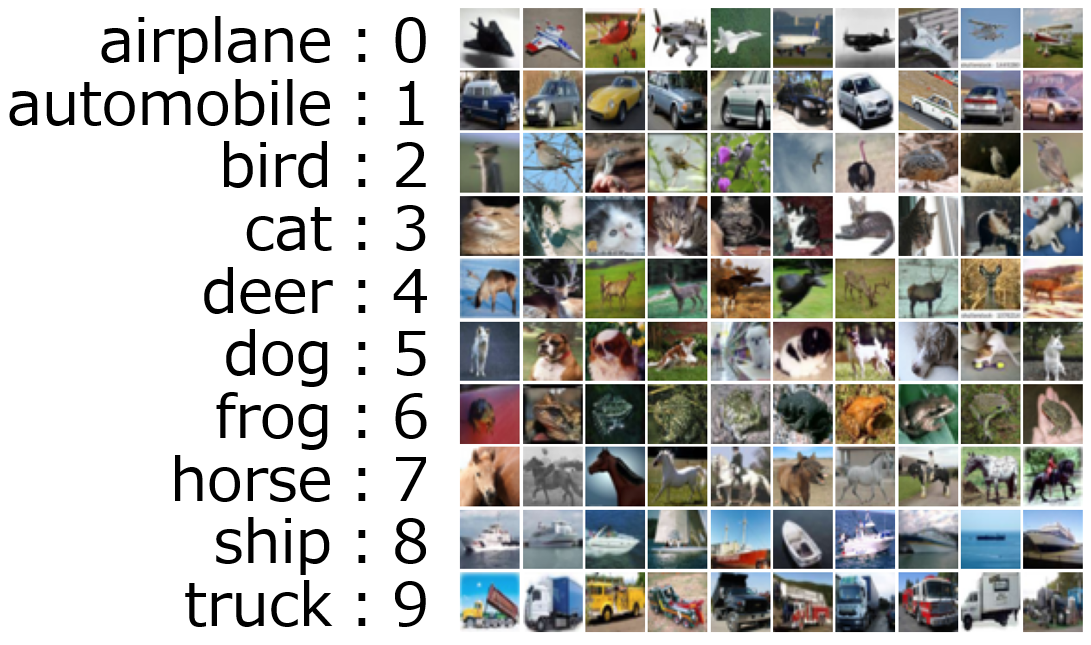

- 이미지 출처: https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
PARAMETER_MAX = 10

# 이미지 정규화를 위한 평균 및 표준편차
mean_cifar10 = (0.4914, 0.4822, 0.4465)
std_cifar10 = (0.2471, 0.2345, 0.2616)

In [3]:
def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)

In [4]:
# Augmentation 함수들을 정의

def AutoContrast(img, **kwargs):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def CutoutAbs(img, v, **kwargs):
    w, h = img.size
    x0, y0 = np.random.uniform(0, w), np.random.uniform(0, h)
    x0, y0 = int(max(0, x0 - v / 2.)), int(max(0, y0 - v / 2.))

    x1, y1 = int(min(w, x0 + v)), int(min(h, y0 + v))

    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def Equalize(img, **kwargs):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwargs):
    return img


def Invert(img, **kwargs):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))

In [5]:
# RandAugment를 사용하기 위한 전체 Augmentation List를 정의

def fixmatch_augment_pool():
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
    return augs

In [6]:
# 위에서 구현된 Augmentpool에서 랜덤으로 선정하여 실제 Augmentation을 구현

class RandAugmentMC(object):
    
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()
    
    def __call__(self, img):
        
        '''
        1. 함수가 불리면 augment_pool에서 n개만큼 선택
        2. m범위에서 랜덤하게 operation 강도를 선정
        3. 50$의 확률로 위 2가지 과정을 진행할지 결정
        4. 마지막에는 Cutout Augmentation 진행
        '''
        
        ops = random.choices(self.augment_pool, k=self.n)
        
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)

        img = CutoutAbs(img, int(32*0.5))
        
        return img

In [7]:
# train_data를 생성하는 함수

class CIFAR10_SSL(datasets.CIFAR10):
    
    def __init__(self, root, indexs, train=True,
                transform=None, target_transform=None,
                download=False):

        super(CIFAR10_SSL, self).__init__(
            root, train=train, transform=transform,
            target_transform=target_transform, download=download
        )

        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]
    
    def __getitem__(self, index):
        
        '''
        getitem: index에 접근할 때 작동하는 함수
        1. self.data 및 self.targets (즉, train_x, train_y)에서 각각 index에 해당하는 값을 불러온다.
        2. transform이 지정되었다면, img를 Transform(Augmentation) 진행
        '''
        
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)
        
        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target

In [8]:
# weak_augmentation과 strong_augmentation된 객체를 반환

class TransformFlexMatch(object):
    
    def __init__(self, mean=mean_cifar10, std=std_cifar10):
        
        '''
        Augmentation하는 함수 초깃값 지정
        self.weak_transform: 약한 왜곡의 Augmentation으로 구성
        self.strong_transform: 큰 왜곡의 Augmentation으로 구성 --> Weak Augmentation에 추가적인 왜곡을 지정
        self.normalize: 정규화하는 함수 정의 ((N, H, W, C)-> (N, C, H, W))
        '''
        
        self.weak_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32,
                                padding=int(32*0.125),
                                padding_mode='reflect')
        ])

        self.strong_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(size=32,
                                padding=int(32*0.125),
                                padding_mode='reflect'),
            RandAugmentMC(n=2, m=10)
        ])

        self.normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ]) 
    
    
    def __call__(self, x):
        
        '''
        함수가 불리면 Weak Aug객체와 Strong Aug객체를 각각 생성 후 정규화한 값들을 반환
        '''
        
        weak = self.weak_transform(x)
        strong = self.strong_transform(x)

        return self.normalize(weak), self.normalize(strong)

In [9]:
# Labeled data와 Unlabeled data를 분리

def split_labeled_unlabeled(args, labels):
    
    '''
    1. 클래스 당 Labeled data의 개수를 정의
    2. Labeled data, Unlabeled data, Validation data의 Index를 담을 수 있는 List 초기화
    3. 각 Label별로 1에서 정의한 개수만큼 Labeled data를 지정하고, Validation data는 500개, 그 외 데이터는 모두 Unlabeled data로 지정
    4. 각 Index를 Shuffle
    5. Return Labeled data의 Index, Unlabeled data의 Index, Validation data의 Index
    '''
    
    label_per_class = args.n_labeled // args.n_classes
    labels = np.array(labels, dtype=int)
    indice_labeled, indice_unlabeled, indice_val = [], [], []

    for i in range(10):
        indice_tmp = np.where(labels==i)[0]

        indice_labeled.extend(indice_tmp[: label_per_class])
        indice_unlabeled.extend(indice_tmp[label_per_class: -500])
        indice_val.extend(indice_tmp[-500: ])
    
    for i in [indice_labeled, indice_unlabeled, indice_val]:
        np.random.shuffle(i)
    
    return np.array(indice_labeled), np.array(indice_unlabeled), np.array(indice_val)

In [10]:
def get_cifar10(args, data_dir):
    
    '''
    1. labeled data의 tranform정의 
    2. validation data의 tranform 정의: 정규화만 진행
    3. Cifar10 데이터셋을 불러온 후 Index에 따라 Labeled, Unlabeled, Validation data를 분류
    '''
    
    transform_labeled = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(size=32, padding=int(32*0.125), padding_mode='reflect'),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_cifar10, std=std_cifar10)
    ])

    transform_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_cifar10, std=std_cifar10)
    ])

    base_dataset = datasets.CIFAR10(data_dir, train=True, download=True)

    indice_labeled, indice_unlabeled, indice_val = split_labeled_unlabeled(args, base_dataset.targets)

    '''
    4. labeled dataset에 대해서는 transform_labeled augmentation 만 적용
    5. Unlabeled dataset에 대해서는 transform_labeled augmentation 및 strong augmentation 동시 적용 
    6. validation, test dataset에 대해서는 ToTensor & Normalization transformation 만 적용
    '''
    
    labeled_dataset = CIFAR10_SSL(
        data_dir, indice_labeled, train=True,
        transform=transform_labeled
    )

    unlabeled_dataset = CIFAR10_SSL(
        data_dir, indice_unlabeled, train=True,
        transform=TransformFlexMatch(mean=mean_cifar10, std=std_cifar10)
    )

    val_dataset = CIFAR10_SSL(
        data_dir, indice_val, train=True, transform=transform_val, download=False
    )

    test_dataset = datasets.CIFAR10(
        data_dir, train=False, transform=transform_val, download=False
    )
    
    return labeled_dataset, unlabeled_dataset, val_dataset, test_dataset

# Backborn classifier (WideResNet)

논문에서 설명된 것 처럼 WideResNet을 통해 분류기를 구현했습니다. WideResNet 코드의 경우, 직접 구현하지 않고 아래의 github 링크에서 발췌하여 사용하였습니다.

WideResNet(WRN)에 대한 간략한 설명을 하자면 다음과 같습니다.

**<span style="color:blue">WRN은 residual netowrk의 넓이를 증가시키고 깊이를 감소시킨 모델로, 16 layer로 이루어진 WRN은 1000-layer ResNet 같은 깊은 신경망을 제치고 SOTA를 달성 (2016년).</span>**

**<span style="color:blue">신경망의 넓이를 증가한다는 의미는 filter수를 증가시킨다는 것을 의미합니다. 즉, WRN은 residual block을 구성하는 convolution layer의 filter 수를 증가시켜서 신경망의 넓이를 증가시켰습니다.</span>**

**<span style="color:blue">따라서, WRN은 (1) 문제를 넓이를 증가시켜서 해결하려 하고, (2) 문제는 residual block 내에있는 conv layer 사이에 dropout을 적용하여 해결합니다.</span>**

- diminishig feature reuse 문제를 다루기 위해 residual block에 dropout을 적용

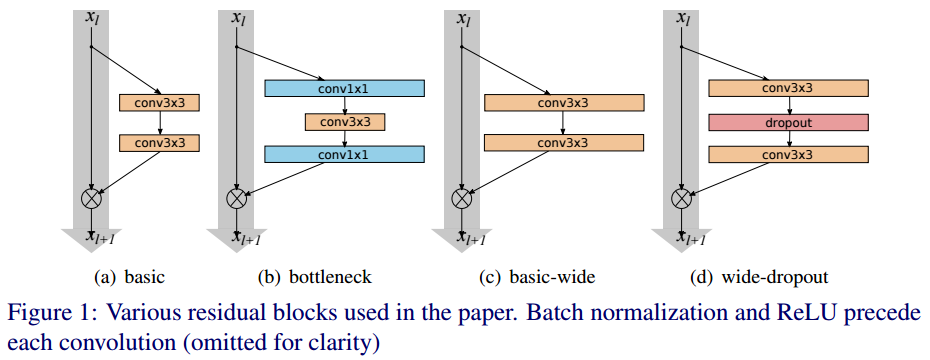

- 이 구조는 모델을 얇게 해 parameter 수를 감소시켜 깊이를 증가시킵니다. residual block을 최대한 얇게 구성하여 모델의 깊이를 엄청나게 증가시킴

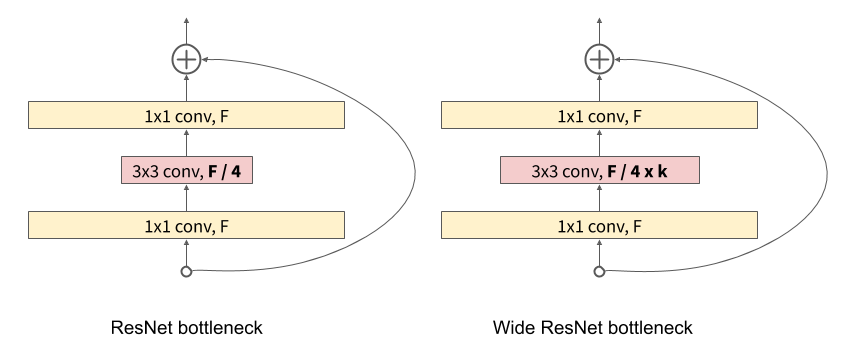

- 출처: https://github.com/xternalz/WideResNet-pytorch/blob/master/wideresnet.py

- 출처: https://deep-learning-study.tistory.com/519

In [11]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual
    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

In [12]:
class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate, activate_before_residual))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

In [13]:
class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [14]:
# WeightEMA로 Parameter를 Update하는 함수를 정의 (EMA=Exponential Moving Average)

class WeightEMA(object): 
    
    '''
    MixMatch와 hyperparameter 이름만 변경
    WeightEMA를 하는 이유는 학습시간이 길어지거나, Trivial Solution을 방지, 과적합 방지 등. 
    --> 가중치를 업데이트 시 a(최근가중치)+(1-a)(이전가중치)
    --> summary: ema_params_new = self.decay*ema_params_old + (1-self.decay)*params
    '''
    
    def __init__(self, model, decay):
        
        self.ema = copy.deepcopy(model)
        self.ema.eval()

        self.decay = decay

        self.ema_has_module = hasattr(self.ema, 'module')

        self.param_keys = [k for k, _ in self.ema.named_parameters()]
        self.buffer_keys = [k for k, _ in self.ema.named_buffers()]
        for p in self.ema.parameters():
            p.requires_grad_(False)

    def step(self, model):
        needs_module = hasattr(model, 'module') and not self.ema_has_module
        with torch.no_grad():
            msd = model.state_dict()
            esd = self.ema.state_dict()
            for k in self.param_keys:
                if needs_module:
                    j = 'module.' + k
                else:
                    j = k
                model_v = msd[j].detach()
                ema_v = esd[k]
                esd[k].copy_(ema_v * self.decay + (1. - self.decay) * model_v)

            for k in self.buffer_keys:
                if needs_module:
                    j = 'module.' + k
                else:
                    j = k
                esd[k].copy_(msd[j])

# Evaluation metric

top1 accuracy, top5 accuracy

    - top1 accuracy: (확률 값이 가장 높은 범주와 실제 범주가 일치하는 관측치 수)/ 전체 관측치
    - top5 accuracy: (확률 값 상위 5개 중 실제 범주가 존재하는 관측치 수)/ 전체 관측치

In [15]:
def accuracy(output, target, topk=(1, )):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        if k == 1:
            correct_k = correct[:k].view(-1).float().sum(0)
        if k > 1:
            correct_k = correct[:k].float().sum(0).sum(0)
        acc = correct_k.mul_(100.0 / batch_size)
        acc = acc.detach().cpu().numpy()
        res.append(acc)
    return res

In [16]:
def get_tqdm_config(total, leave=True, color='white'):
    fore_colors = {
        'red': Fore.LIGHTRED_EX,
        'green': Fore.LIGHTGREEN_EX,
        'yellow': Fore.LIGHTYELLOW_EX,
        'blue': Fore.LIGHTBLUE_EX,
        'magenta': Fore.LIGHTMAGENTA_EX,
        'cyan': Fore.LIGHTCYAN_EX,
        'white': Fore.LIGHTWHITE_EX,
    }
    return {
        'file': sys.stdout,
        'total': total,
        'desc': " ",
        'dynamic_ncols': True,
        'bar_format':
            "{l_bar}%s{bar}%s| [{elapsed}<{remaining}, {rate_fmt}{postfix}]" % (fore_colors[color], Fore.RESET),
        'leave': leave
    }

In [17]:
# Warmup을 적용한 Learning rate Scheduler 적용
def get_cosine_schedule_with_warmup(
    optimizer, num_warmup_steps, num_training_steps,
    num_cycles=7.0/16.0, last_epoch=-1
    ):
    
    def _lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step)/float(max(1, num_warmup_steps))
        
        no_progress = float(current_step-num_warmup_steps)/\
            (float(max(1, num_training_steps-num_warmup_steps)))
        return max(0.0, math.cos(math.pi*num_cycles*no_progress))
    
    return LambdaLR(optimizer, _lr_lambda, last_epoch)

# Train & Test with FixMatch using WideResnet

In [18]:
# trainer를 정의
class FlexMatchTrainer():
    
    '''
    DataLoader 내 num_workers 옵션에 대한 사설
    Window10는 다중 CPU 코어 사용 시 순차적으로 작동 시작
    Linux(Ubuntu, CentOS) 계열은 동시에 CPU 코어 작동을 시작 가능
    (Windows10+PyTorch)를 사용해 Deep Learning 모델 학습 시 num_workers=0을 사용하는 것을 권유
    (Linux계열 운영체제+PyTorch)를 사용해 Deep Learning 모델 학습 시 CPU&GPU 사용량이 최대가 될 수 있도록 num_workers 조정 권유
    '''
    
    # 초깃값 지정
    def __init__(self, args, c_threshold):
        
        '''
        초깃값 지정
        1. argument
        2. directory
        3. Dataset
        4. DataLoader
        5. Model(EMA Model), Optimzer, Model_parameter, LR Scheduler, Loss Function
        6. Tensorboard 객체
        '''
        
        # argment를 받아오기
        self.args = args
        self.c_threshold = c_threshold
        
        # 각종 Directory를 지정
        root_dir = '/content/FlexMatch' ### Project Directory
        data_dir = os.path.join(root_dir, 'data') ### Data Directory
        
        self.experiment_dir = os.path.join(root_dir, 'results') ### 학습된 모델을 저장할 큰 폴더
        os.makedirs(self.experiment_dir, exist_ok=True)

        name_exp = "_".join([str(self.args.n_labeled), str(self.args.T)]) ### 학습된 모델을 저장할 세부 폴더 (하이퍼파라미터로 지정)
        self.experiment_dir = os.path.join(self.experiment_dir, name_exp)
        os.makedirs(self.experiment_dir, exist_ok=True)
        
        # Load Dataset (Labeled, Unlabeled, Valid, Test dataset)
        print("==> Preparing CIFAR10 dataset")
        labeled_set, unlabeled_set, val_set, test_set = get_cifar10(self.args, data_dir=data_dir)
        
        # DataLoader를 각각 정의 (Labeled, Unlabeled, Valid, Test dataset)                 
        self.labeled_loader = DataLoader(
            labeled_set,
            sampler=RandomSampler(labeled_set), ### RandomSampler: DataLoader(shuffle=True) 와 동일한 역할
            batch_size=self.args.batch_size,
            num_workers=0,
            drop_last=True
        )

        self.unlabeled_loader = DataLoader(
            unlabeled_set,
            sampler=RandomSampler(unlabeled_set),
            batch_size=self.args.batch_size,
            num_workers=0,
            drop_last=True
        )

        self.val_loader = DataLoader(
            val_set,
            sampler=SequentialSampler(val_set), ### SequentialSampler: DataLoader(shuffle=False) 와 동일한 역할
            batch_size=self.args.batch_size,
            num_workers=0,
            drop_last=True
        )

        self.test_loader = DataLoader(
            test_set,
            sampler=SequentialSampler(test_set),
            batch_size=self.args.batch_size,
            num_workers=0
        )

        # WideResNet모델 정의
        print("==> Preparing WideResNet")
        self.model = WideResNet(self.args.n_classes).to(self.args.cuda)
        
        # 모델의 Gradient 초기화 및 Loss Function을 정의
        self.model.zero_grad()
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.cuda)

        # Optimzer를 정의: params의 이름 내 bias, bn이 들어가지 않는 경우에만 weight_decay 적용
        no_decay = ['bias', 'bn']
        grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(
                nd in n for nd in no_decay)], 'weight_decay': self.args.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(
                nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 
        self.optimizer = torch.optim.SGD(grouped_parameters, lr=self.args.lr,
                            momentum=0.9, nesterov=self.args.nesterov)
        
        # Learning rate Scheduler를 적용
        
        '''
        Learning scheduler의 경우 사용이 까다로움
         - 특정 scheduler는 각각 iteration 마다 step을 진행
         - 또 다른 scheduler그룹은 한 epoch 종료 후 step 진행
         - 아래 Documentation 에서 사용할 lr_scheduler에 대한 설명을 정확히 읽고 사용
           - https://pytorch.org/docs/stable/optim.html
        '''
        
        self.scheduler = get_cosine_schedule_with_warmup(self.optimizer,
                                                    self.args.warmup,
                                                    self.args.total_steps)
        
        # EMA Model을 쓸건지 안 쓸건지 명시
        if self.args.use_ema:  
            self.ema_model = WeightEMA(self.model, self.args.ema_decay)
        
        # Tensorboard에 기록할 객체 정의
        self.writer = SummaryWriter(self.experiment_dir)

        
    # train을 위한 함수
    def train(self, epoch):
        
        # total, labeled, unlabeled loss 초기화 및 Mask probs(Threshold를 넘었는지 여부를 표시한 것) 초기화
        losses_t, losses_x, losses_u, mask_probs = 0.0, 0.0, 0.0, 0.0
        
        # 훈련모드 전환
        self.model.train()
        
        # iter함수로 Labeled data 및 Unlabeled data 불러오기
        iter_labeled = iter(self.labeled_loader)
        iter_unlabeled = iter(self.unlabeled_loader)
        
        over_threshold_count = [0] * 10 ### 각 Class별 초과한 Instance의 수를 초기화
        under_threshold_count = 0 ### 각 Class별 초과하지 않은 Instance 값을 초기화
        
        with tqdm(**get_tqdm_config(total=self.args.eval_step,
                leave=True, color='blue')) as pbar:
            
            for batch_idx in range(self.args.eval_step): ### eval_step: 1024 // batch_size: 64
                 # - 코드 작성 후 iter&next가 정확히 작용하지 않는 경우가 있음을 확인
                 # - 다시 iter_labeled, iter_unlabeled를 정의해 학습에 문제가 없도록 다시 선언
                ### Labeled Data(각각 데이터와 Target)
                try:
                    inputs_x, targets_x = next(iter_labeled)
                except:
                    iter_labeled = iter(self.labeled_loader)
                    inputs_x, targets_x = next(iter_labeled)
                real_B = inputs_x.size(0)
                
                ### Unlabeled Data (각각 Weak Aug, Strong Aug)
                try:
                    (inputs_u_w, inputs_u_s), _ = next(iter_unlabeled)
                except:
                    iter_unlabeled = iter(self.unlabeled_loader)
                    (inputs_u_w, inputs_u_s), _ = next(iter_unlabeled)
                
                ### Labeled data, Weak_aug Unlabeled data, Strong_aug Unlabeled data Concat하여 Input으로 활용
                inputs = torch.cat((inputs_x, inputs_u_w, inputs_u_s), dim=0).to(self.args.cuda)
                targets_x = targets_x.type(torch.LongTensor)
                targets_x = targets_x.to(self.args.cuda)
                
                logits = self.model(inputs) ##### 예측값이 들어있음
                
                ### Labeled data와 Unlabeled data를 구분
                
                '''
                real_B까지가 Labeled data Index, 그 외가 Unlabeled임
                --> chunk함수로 weak_aug 및 strong_aug 구분 (Unlabeled data에 이미 weak, strong aug 각각 적용한 객체가 남아있는 형태)
                '''
                
                logits_x = logits[:real_B]
                logits_u_w, logits_u_s = logits[real_B:].chunk(2)
                del(logits)

                # Labeled data에 대한 loss계산
                loss_x = F.cross_entropy(logits_x, targets_x, reduction='mean')

                # Unlabeled data에 대한 loss계산
                
                '''
                Unlabeled 데이터에 대한 로짓 산출 및 Temparature hyperparameter를 사용한 Sharpening
                 --> Pseudo label 생성
                1) Unlabeled data에 대한 예측값(logits_u_w)에 Softmax를 통과시킨 후 Sharpen 적용
                2) 가장 높은 확률을 Label로 지정 (targets_u)
                3) threshold값과 비교하여 mask 객체 생성
                 - 이는 각 샘플에 대하여 확률이 도출되고, 배치 내 있는 데이터 만큼 Threshold를 넘었는지 여부를 T/F로 도출 [T, T, F, T..]
                 - 근데, 지금 1개씩 가져와서 실험하다보니 결국 1개 sample에 대해서만 진행
                '''
                
                ### 예측 결과 --> return 예측한 Class, Threshold를 넘은 여부
                pseudo_labels = torch.softmax(logits_u_w.detach()/self.args.T, dim=-1) 
                max_prob, targets_u = torch.max(pseudo_labels, dim=-1)
                mask = torch.tensor([max_prob[idx].ge(self.c_threshold[idx]).float() for idx in targets_u])
                
                # Class를 넘은 여부를 기록
                for mask_value, class_idx in zip(mask, targets_u):
                    if mask_value == 0:
                        under_threshold_count += 1

                    elif mask_value == 1:
                        over_threshold_count[class_idx] += 1

                ### strong augmentation된 이미지에서 산출된 logit과 Pseudo label 사이 cross_entropy 계산
                
                '''
                여기서 mask를 곱해줌으로써 True면 1, False면 0을 곱해주게 된다.
                --> 이를 통해 False일 경우 Loss연산에 이를 반영하지 않음
                '''
                logits_u_s = logits_u_s.to(self.args.cuda)
                targets_u = targets_u.to(self.args.cuda)
                mask = mask.to(self.args.cuda)
                loss_u = (F.cross_entropy(logits_u_s, targets_u, reduction='none')*mask).mean()
                
                ### Total loss: Labeled data loss와 Unlabeled data loss의 가중합
                loss = loss_x + self.args.lambda_u * loss_u
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()
                if self.args.use_ema:
                    self.ema_model.step(self.model)
                
                self.model.zero_grad()
                
                ### Threshold를 Update 
                
                '''
                 0) 추후배치를 모두 다 돌고 나서 진행하는 과정
                 1) 각 Class별로 다른 Threshold를 주어야함
                 2) 초기에 Warmup과정 넣어줄 것
                 3) 비선형 Mapping함수 활용 (y = x/2-x)
                '''

                if max(over_threshold_count) < under_threshold_count: ### Warmup
                    for idx in range(10):
                        beta = over_threshold_count[idx] / max(max(over_threshold_count), under_threshold_count)
                        self.c_threshold[idx] = (beta/(2-beta)) * self.args.threshold

                else:
                    for idx in range(10):
                        beta = over_threshold_count[idx] / max(over_threshold_count) 
                        self.c_threshold[idx] = (beta/(2-beta)) * self.args.threshold
                
                ### Tensorboard를 위해 loss값들을 기록
                losses_x += loss_x.item()
                losses_u += loss_u.item()
                losses_t += loss.item()
                mask_probs += max_prob.mean().item()
                
                ### Print log
                self.writer.add_scalars(
                    'Training steps', {
                        'Total_loss': losses_t/(batch_idx+1),
                        'Labeled_loss':losses_x/(batch_idx+1),
                        'Unlabeled_loss':losses_u/(batch_idx+1),
                        'Mask probs': mask_probs/(batch_idx+1)
                    }, global_step=epoch*self.args.batch_size+batch_idx
                )

                pbar.set_description(
                    '[Train(%4d/ %4d)-Total: %.3f|Labeled: %.3f|Unlabeled: %.3f]'%(
                        (batch_idx+1), self.args.eval_step,
                        losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)
                    )
                )
                pbar.update(1)

            pbar.set_description(
                '[Train(%4d/ %4d)-Total: %.3f|Labeled: %.3f|Unlabeled: %.3f]'%(
                    epoch, self.args.epochs,
                    losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)
                )
            )
            
        print(f'Threshold_per_class: {self.c_threshold}')
        
        return losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1), self.c_threshold

    
    # Validation 함수 (MixMatch와 동일)
    @torch.no_grad()
    def validate(self, epoch, phase):
        if phase == 'Train': ### Train Loss
            data_loader = self.labeled_loader
            c = 'blue'
        elif phase == 'Valid': ### Valid Loss
            data_loader = self.val_loader
            c = 'green'
        elif phase == 'Test ': ### Test Loss
            data_loader = self.test_loader
            c = 'red'
        
        ### 값 초기화
        losses = 0.0
        top1s, top5s = [], []
        
        ### 데이터를 넣은 후 Output 및 Loss값, 정확도 산출
        with tqdm(**get_tqdm_config(total=len(data_loader),
                leave=True, color=c)) as pbar:
            for batch_idx, (inputs, targets) in enumerate(data_loader):
                
                targets = targets.type(torch.LongTensor)
                inputs, targets = inputs.to(self.args.cuda), targets.to(self.args.cuda)

                outputs = self.ema_model.ema(inputs)
                loss = self.criterion(outputs, targets)

                prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
                losses += loss.item()
                top1s.append(prec1)
                top5s.append(prec5)

                self.writer.add_scalars(
                    f'{phase} steps', {
                        'Total_loss': losses/(batch_idx+1),
                        'Top1 Acc': np.mean(top1s),
                        'Top5 Acc': np.mean(top5s)
                    }, global_step=epoch*self.args.batch_size+batch_idx
                )

                pbar.set_description(
                    '[%s-Loss: %.3f|Top1 Acc: %.3f|Top5 Acc: %.3f]'%(
                        phase,
                        losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)
                    )
                )
                pbar.update(1)

            pbar.set_description(
                '[%s(%4d/ %4d)-Loss: %.3f|Top1 Acc: %.3f|Top5 Acc: %.3f]'%(
                    phase,
                    epoch, self.args.epochs,
                    losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)
                )
            )

        return losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)

# hyperparameters setting

In [19]:
# Argument 정의
def FlexMatch_parser():
    parser = argparse.ArgumentParser(description="FlexMatch PyTorch Implementation for BA")
    
    # method arguments
    parser.add_argument('--n-labeled', type=int, default=128) # labeled dat의 수
    parser.add_argument('--n-classes', type=int, default=10) # Class의 수
    parser.add_argument("--expand-labels", action="store_true", 
                        help="expand labels to fit eval steps")

    # training hyperparameters
    parser.add_argument('--batch-size', type=int, default=64) # 배치 사이즈
    parser.add_argument('--total-steps', default=900, type=int) # iteration마다 Scheduler가 적용되기에, Epoch가 아닌, Total-step을 정의
    parser.add_argument('--eval-step', type=int, default=300) # Evaluation Step의 수
    parser.add_argument('--lr', type=float, default=0.03) # Learning rate
    parser.add_argument('--weight-decay', type=float, default=5e-4) # Weight Decay 정도
    parser.add_argument('--nesterov', action='store_true', default=True) # Nesterov Momentum
    parser.add_argument('--warmup', type=float, default=0.0) # Warmup 정도

    parser.add_argument('--use-ema', action='store_true', default=True) # EMA 사용여부
    parser.add_argument('--ema-decay', type=float, default=0.999) # EMA에서 Decay 정도

    parser.add_argument('--mu', type=int, default=7) # Labeled data의 mu배를 Unlabeled 데이터의 개수로 정의하기 위한 함수 (근데 위 Trainer에서는 안 쓰임)
    parser.add_argument('--T', type=float, default=1.0) # Sharpening 함수에 들어가는 하이퍼 파라미터

    parser.add_argument('--threshold', type=float, default=0.95) # Pseudo-Labeling이 진행되는 Threshold 정의
    parser.add_argument('--lambda-u', type=float, default=1.0) # Loss 가중치 정도
    return parser

# Run

In [20]:
# main함수 정의

def main():
    
    '''
    1. 사용자의 Parser를 받아온 후, Cuda지정 및 epoch 산정
    2. Trainer를 정의
    3. Loss값 초기화 
    4. 전체 Loss, Labeled data의 Loss, Unlabeled data의 Loss를 담을 리스트 초기화
    5. Train, Valid, Test 각각에 대해 Loss, top1 acc, top5 acc를 저장하기 위한 리스트 초기화
    6. 각 Epoch 단위로 학습할 때 마다 성능들을 기록 및 Checkpoint 저장
    7. 학습 중 Best_loss보다 개선되면, Best Loss를 변환 및 Model Save
    '''
    
    parser = FlexMatch_parser()
    args = parser.parse_args([])
    args.cuda = torch.device("cuda:0")
    args.epochs = math.ceil(args.total_steps/args.eval_step)
    
    class_threshold = [args.threshold] * 10 ### 각 Class 별 Threshold를 저장할 공간 형성

    trainer = FlexMatchTrainer(args, class_threshold)

    best_loss = np.inf
    losses, losses_x, losses_u = [], [], []
    
    train_losses, train_top1s, train_top5s = [], [], []
    val_losses, val_top1s, val_top5s = [], [], []
    test_losses, test_top1s, test_top5s = [], [], []
            
    # 각 Epoch단위로 학습할 때 마다 성능들을 기록
    for epoch in range(1, args.epochs+1, 1):
        loss, loss_x, loss_u, class_threshold = trainer.train(epoch)
        losses.append(loss)
        losses_x.append(loss_x)
        losses_u.append(loss_u)

        loss, top1, top5 = trainer.validate(epoch, 'Train')
        train_losses.append(loss)
        train_top1s.append(top1)
        train_top5s.append(top5)

        loss, top1, top5 = trainer.validate(epoch, 'Valid')
        val_losses.append(loss)
        val_top1s.append(top1)
        val_top5s.append(top5)

        if loss < best_loss:
            best_loss = loss
            torch.save(trainer.model, os.path.join(trainer.experiment_dir, 'model.pth'))
            torch.save(trainer.ema_model, os.path.join(trainer.experiment_dir, 'ema_model.pth'))

        loss, top1, top5 = trainer.validate(epoch, 'Test ')
        test_losses.append(loss)
        test_top1s.append(top1)
        test_top5s.append(top5)

        torch.save(trainer.model, os.path.join(trainer.experiment_dir, 'checkpooint_model.pth'))
        torch.save(trainer.ema_model, os.path.join(trainer.experiment_dir, 'checkpoint_ema_model.pth'))

In [21]:
if __name__=="__main__":
    main()

==> Preparing CIFAR10 dataset
Files already downloaded and verified
==> Preparing WideResNet
[Train(   1/    3)-Total: 1.930|Labeled: 0.692|Unlabeled: 1.238]: 100%|██████████████████████| [00:42<00:00,  7.12it/s]
Threshold_per_class: [0.4501651073197578, 0.392532981530343, 0.4938706015891033, 0.40108868826340943, 0.41816348480774407, 0.38408495018353433, 0.5079369627507163, 0.36342281879194627, 0.4559684995855209, 0.3861869747899159]
[Train(   1/    3)-Loss: 2.427|Top1 Acc: 17.188|Top5 Acc: 78.125]: 100%|█████████████████████| [00:00<00:00, 25.71it/s]
[Valid(   1/    3)-Loss: 2.823|Top1 Acc: 12.600|Top5 Acc: 60.196]: 100%|█████████████████████| [00:01<00:00, 52.56it/s]
[Test (   1/    3)-Loss: 2.863|Top1 Acc: 13.127|Top5 Acc: 60.241]: 100%|█████████████████████| [00:03<00:00, 49.59it/s]
[Train(   2/    3)-Total: 1.276|Labeled: 0.125|Unlabeled: 1.152]: 100%|██████████████████████| [00:40<00:00,  7.42it/s]
Threshold_per_class: [0.4596774193548387, 0.39971552424817125, 0.47459250786388335

실험 결과를 보면, 우선 학습을 위한 파라미터 설정에 있어서 '--n-labeled' (# 사용할 Labeled data의 수) = 128로 그렇게 많지 않은 labeled data를 주어서 학습이 잘 안될것이라는 예상을 했습니다.

추가로, 지난 MixMatch, FixMatch와 유사한 환경을 만들기 위해, '--batch-size' (# 학습에 사용할 batch size 크기) = 64로 설정하여 그리 좋은 분류 성능이 나올것이라는 예상은 하지 않았지만 결과를 보면 나름 흥미로운 점이 있었습니다.

**<span style="color:blue">학습이 진행될수록, 모든 데이터셋 경우에 대한 Top1, Top5 분류 정확도가 모두 증가하는 것을 확인할 수 있었습니다.</span>**

**<span style="color:blue">그리고 정말 흥미로운 점은 trainset에 대해서 Top5 분류 정확도가 100%를 달성했다는 것이 놀라웠습니다.</span>**

**<span style="color:blue">여기도 마찬가지로, 우연의 일치일 가능성이 매우 크지만 간단한 아이디어와 FixMatch에서의 발전과 변화로 MixMatch보다 훨씬 좋은 성능을 보인 것 같아 신기한 경험이었습니다.</span>**

    - train set에 대한 Top1 분류 정확도가 1: 17.188 -> 2: 45.312 -> 3: 68.750으로 증가
    - validation set에 대한 Top1 분류 정확도가 1: 12.600 -> 2: 20.954 -> 3: 25.180으로 증가
    - test set에 대한 Top1 분류 정확도가 1: 13.127 -> 2: 20.601 -> 3: 24.861으로 증가




    - train set에 대한 Top5 분류 정확도가 1: 78.125 -> 2: 93.750 -> 3: 100.000으로 증가
    - validation set에 대한 Top5 분류 정확도가 1: 60.196 -> 2: 77.103 -> 3: 79.968으로 증가
    - test set에 대한 Top5 분류 정확도가 1: 60.241 -> 2: 77.339 -> 3: 79.877으로 증가

## Hyperparameter (conf_threshold_list)

이어서, FlexMatch의 임계치 파라미터를 변경하였을 때는 어떤 결과가 있을지 비교를 해보겠습니다.

변경할 파라미터와 실험할 값은 아래에 정리하였습니다.

    conf_threshold_list: [0.95, 0.90, 0.80, 0.75, 0.50, 0.10]

### conf_threshold_list [0.95, 0.90, 0.80, 0.75, 0.50, 0.10]

In [22]:
# trainer를 정의
class FlexMatchTrainer():
    
    '''
    DataLoader 내 num_workers 옵션에 대한 사설
    Window10는 다중 CPU 코어 사용 시 순차적으로 작동 시작
    Linux(Ubuntu, CentOS) 계열은 동시에 CPU 코어 작동을 시작 가능
    (Windows10+PyTorch)를 사용해 Deep Learning 모델 학습 시 num_workers=0을 사용하는 것을 권유
    (Linux계열 운영체제+PyTorch)를 사용해 Deep Learning 모델 학습 시 CPU&GPU 사용량이 최대가 될 수 있도록 num_workers 조정 권유
    '''
    
    # 초깃값 지정
    def __init__(self, args, c_threshold):
        
        '''
        초깃값 지정
        1. argument
        2. directory
        3. Dataset
        4. DataLoader
        5. Model(EMA Model), Optimzer, Model_parameter, LR Scheduler, Loss Function
        6. Tensorboard 객체
        '''
        
        # argment를 받아오기
        self.args = args
        self.c_threshold = c_threshold
        
        # 각종 Directory를 지정
        root_dir = '/content/FlexMatch' ### Project Directory
        data_dir = os.path.join(root_dir, 'data') ### Data Directory
        
        self.experiment_dir = os.path.join(root_dir, 'results') ### 학습된 모델을 저장할 큰 폴더
        os.makedirs(self.experiment_dir, exist_ok=True)

        name_exp = "_".join([str(self.args.n_labeled), str(self.args.T)]) ### 학습된 모델을 저장할 세부 폴더 (하이퍼파라미터로 지정)
        self.experiment_dir = os.path.join(self.experiment_dir, name_exp)
        os.makedirs(self.experiment_dir, exist_ok=True)
        
        # Load Dataset (Labeled, Unlabeled, Valid, Test dataset)
        print("==> Preparing CIFAR10 dataset")
        labeled_set, unlabeled_set, val_set, test_set = get_cifar10(self.args, data_dir=data_dir)
        
        # DataLoader를 각각 정의 (Labeled, Unlabeled, Valid, Test dataset)                 
        self.labeled_loader = DataLoader(
            labeled_set,
            sampler=RandomSampler(labeled_set), ### RandomSampler: DataLoader(shuffle=True) 와 동일한 역할
            batch_size=self.args.batch_size,
            num_workers=0,
            drop_last=True
        )

        self.unlabeled_loader = DataLoader(
            unlabeled_set,
            sampler=RandomSampler(unlabeled_set),
            batch_size=self.args.batch_size,
            num_workers=0,
            drop_last=True
        )

        self.val_loader = DataLoader(
            val_set,
            sampler=SequentialSampler(val_set), ### SequentialSampler: DataLoader(shuffle=False) 와 동일한 역할
            batch_size=self.args.batch_size,
            num_workers=0,
            drop_last=True
        )

        self.test_loader = DataLoader(
            test_set,
            sampler=SequentialSampler(test_set),
            batch_size=self.args.batch_size,
            num_workers=0
        )

        # WideResNet모델 정의
        print("==> Preparing WideResNet")
        self.model = WideResNet(self.args.n_classes).to(self.args.cuda)
        
        # 모델의 Gradient 초기화 및 Loss Function을 정의
        self.model.zero_grad()
        self.criterion = torch.nn.CrossEntropyLoss().to(self.args.cuda)

        # Optimzer를 정의: params의 이름 내 bias, bn이 들어가지 않는 경우에만 weight_decay 적용
        no_decay = ['bias', 'bn']
        grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(
                nd in n for nd in no_decay)], 'weight_decay': self.args.weight_decay},
            {'params': [p for n, p in self.model.named_parameters() if any(
                nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 
        self.optimizer = torch.optim.SGD(grouped_parameters, lr=self.args.lr,
                            momentum=0.9, nesterov=self.args.nesterov)
        
        # Learning rate Scheduler를 적용
        
        '''
        Learning scheduler의 경우 사용이 까다로움
         - 특정 scheduler는 각각 iteration 마다 step을 진행
         - 또 다른 scheduler그룹은 한 epoch 종료 후 step 진행
         - 아래 Documentation 에서 사용할 lr_scheduler에 대한 설명을 정확히 읽고 사용
           - https://pytorch.org/docs/stable/optim.html
        '''
        
        self.scheduler = get_cosine_schedule_with_warmup(self.optimizer,
                                                    self.args.warmup,
                                                    self.args.total_steps)
        
        # EMA Model을 쓸건지 안 쓸건지 명시
        if self.args.use_ema:  
            self.ema_model = WeightEMA(self.model, self.args.ema_decay)
        
        # Tensorboard에 기록할 객체 정의
        self.writer = SummaryWriter(self.experiment_dir)

        
    # train을 위한 함수
    def train(self, epoch):
        
        # total, labeled, unlabeled loss 초기화 및 Mask probs(Threshold를 넘었는지 여부를 표시한 것) 초기화
        losses_t, losses_x, losses_u, mask_probs = 0.0, 0.0, 0.0, 0.0
        
        # 훈련모드 전환
        self.model.train()
        
        # iter함수로 Labeled data 및 Unlabeled data 불러오기
        iter_labeled = iter(self.labeled_loader)
        iter_unlabeled = iter(self.unlabeled_loader)
        
        over_threshold_count = [0] * 10 ### 각 Class별 초과한 Instance의 수를 초기화
        under_threshold_count = 0 ### 각 Class별 초과하지 않은 Instance 값을 초기화
        
        with tqdm(**get_tqdm_config(total=self.args.eval_step,
                leave=True, color='blue')) as pbar:
            
            for batch_idx in range(self.args.eval_step): ### eval_step: 1024 // batch_size: 64
                 # - 코드 작성 후 iter&next가 정확히 작용하지 않는 경우가 있음을 확인
                 # - 다시 iter_labeled, iter_unlabeled를 정의해 학습에 문제가 없도록 다시 선언
                ### Labeled Data(각각 데이터와 Target)
                try:
                    inputs_x, targets_x = next(iter_labeled)
                except:
                    iter_labeled = iter(self.labeled_loader)
                    inputs_x, targets_x = next(iter_labeled)
                real_B = inputs_x.size(0)
                
                ### Unlabeled Data (각각 Weak Aug, Strong Aug)
                try:
                    (inputs_u_w, inputs_u_s), _ = next(iter_unlabeled)
                except:
                    iter_unlabeled = iter(self.unlabeled_loader)
                    (inputs_u_w, inputs_u_s), _ = next(iter_unlabeled)
                
                ### Labeled data, Weak_aug Unlabeled data, Strong_aug Unlabeled data Concat하여 Input으로 활용
                inputs = torch.cat((inputs_x, inputs_u_w, inputs_u_s), dim=0).to(self.args.cuda)
                targets_x = targets_x.type(torch.LongTensor)
                targets_x = targets_x.to(self.args.cuda)
                
                logits = self.model(inputs) ##### 예측값이 들어있음
                
                ### Labeled data와 Unlabeled data를 구분
                
                '''
                real_B까지가 Labeled data Index, 그 외가 Unlabeled임
                --> chunk함수로 weak_aug 및 strong_aug 구분 (Unlabeled data에 이미 weak, strong aug 각각 적용한 객체가 남아있는 형태)
                '''
                
                logits_x = logits[:real_B]
                logits_u_w, logits_u_s = logits[real_B:].chunk(2)
                del(logits)

                # Labeled data에 대한 loss계산
                loss_x = F.cross_entropy(logits_x, targets_x, reduction='mean')

                # Unlabeled data에 대한 loss계산
                
                '''
                Unlabeled 데이터에 대한 로짓 산출 및 Temparature hyperparameter를 사용한 Sharpening
                 --> Pseudo label 생성
                1) Unlabeled data에 대한 예측값(logits_u_w)에 Softmax를 통과시킨 후 Sharpen 적용
                2) 가장 높은 확률을 Label로 지정 (targets_u)
                3) threshold값과 비교하여 mask 객체 생성
                 - 이는 각 샘플에 대하여 확률이 도출되고, 배치 내 있는 데이터 만큼 Threshold를 넘었는지 여부를 T/F로 도출 [T, T, F, T..]
                 - 근데, 지금 1개씩 가져와서 실험하다보니 결국 1개 sample에 대해서만 진행
                '''
                
                ### 예측 결과 --> return 예측한 Class, Threshold를 넘은 여부
                pseudo_labels = torch.softmax(logits_u_w.detach()/self.args.T, dim=-1) 
                max_prob, targets_u = torch.max(pseudo_labels, dim=-1)
                mask = torch.tensor([max_prob[idx].ge(self.c_threshold[idx]).float() for idx in targets_u])
                
                # Class를 넘은 여부를 기록
                for mask_value, class_idx in zip(mask, targets_u):
                    if mask_value == 0:
                        under_threshold_count += 1

                    elif mask_value == 1:
                        over_threshold_count[class_idx] += 1

                ### strong augmentation된 이미지에서 산출된 logit과 Pseudo label 사이 cross_entropy 계산
                
                '''
                여기서 mask를 곱해줌으로써 True면 1, False면 0을 곱해주게 된다.
                --> 이를 통해 False일 경우 Loss연산에 이를 반영하지 않음
                '''
                logits_u_s = logits_u_s.to(self.args.cuda)
                targets_u = targets_u.to(self.args.cuda)
                mask = mask.to(self.args.cuda)
                loss_u = (F.cross_entropy(logits_u_s, targets_u, reduction='none')*mask).mean()
                
                ### Total loss: Labeled data loss와 Unlabeled data loss의 가중합
                loss = loss_x + self.args.lambda_u * loss_u
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()
                if self.args.use_ema:
                    self.ema_model.step(self.model)
                
                self.model.zero_grad()
                
                ### Threshold를 Update 
                
                '''
                 0) 추후배치를 모두 다 돌고 나서 진행하는 과정
                 1) 각 Class별로 다른 Threshold를 주어야함
                 2) 초기에 Warmup과정 넣어줄 것
                 3) 비선형 Mapping함수 활용 (y = x/2-x)
                '''

                if max(over_threshold_count) < under_threshold_count: ### Warmup
                    for idx in range(10):
                        beta = over_threshold_count[idx] / max(max(over_threshold_count), under_threshold_count)
                        self.c_threshold[idx] = (beta/(2-beta)) * self.args.threshold

                else:
                    for idx in range(10):
                        beta = over_threshold_count[idx] / max(over_threshold_count) 
                        self.c_threshold[idx] = (beta/(2-beta)) * self.args.threshold
                
                ### Tensorboard를 위해 loss값들을 기록
                losses_x += loss_x.item()
                losses_u += loss_u.item()
                losses_t += loss.item()
                mask_probs += max_prob.mean().item()
                
                ### Print log
                self.writer.add_scalars(
                    'Training steps', {
                        'Total_loss': losses_t/(batch_idx+1),
                        'Labeled_loss':losses_x/(batch_idx+1),
                        'Unlabeled_loss':losses_u/(batch_idx+1),
                        'Mask probs': mask_probs/(batch_idx+1)
                    }, global_step=epoch*self.args.batch_size+batch_idx
                )

                pbar.set_description(
                    '[Train(%4d/ %4d)-Total: %.3f|Labeled: %.3f|Unlabeled: %.3f]'%(
                        (batch_idx+1), self.args.eval_step,
                        losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)
                    )
                )
                pbar.update(1)

            pbar.set_description(
                '[Train(%4d/ %4d)-Total: %.3f|Labeled: %.3f|Unlabeled: %.3f]'%(
                    epoch, self.args.epochs,
                    losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1)
                )
            )
            
        print(f'Threshold_per_class: {self.c_threshold}')
        
        return losses_t/(batch_idx+1), losses_x/(batch_idx+1), losses_u/(batch_idx+1), self.c_threshold

    
    # Validation 함수 (MixMatch와 동일)
    @torch.no_grad()
    def validate(self, epoch, phase):
        if phase == 'Train': ### Train Loss
            data_loader = self.labeled_loader
            c = 'blue'
        elif phase == 'Valid': ### Valid Loss
            data_loader = self.val_loader
            c = 'green'
        elif phase == 'Test ': ### Test Loss
            data_loader = self.test_loader
            c = 'red'
        
        ### 값 초기화
        losses = 0.0
        top1s, top5s = [], []
        
        ### 데이터를 넣은 후 Output 및 Loss값, 정확도 산출
        with tqdm(**get_tqdm_config(total=len(data_loader),
                leave=True, color=c)) as pbar:
            for batch_idx, (inputs, targets) in enumerate(data_loader):
                
                targets = targets.type(torch.LongTensor)
                inputs, targets = inputs.to(self.args.cuda), targets.to(self.args.cuda)

                outputs = self.ema_model.ema(inputs)
                loss = self.criterion(outputs, targets)

                prec1, prec5 = accuracy(outputs, targets, topk=(1, 5))
                losses += loss.item()
                top1s.append(prec1)
                top5s.append(prec5)

                self.writer.add_scalars(
                    f'{phase} steps', {
                        'Total_loss': losses/(batch_idx+1),
                        'Top1 Acc': np.mean(top1s),
                        'Top5 Acc': np.mean(top5s)
                    }, global_step=epoch*self.args.batch_size+batch_idx
                )

                pbar.set_description(
                    '[%s-Loss: %.3f|Top1 Acc: %.3f|Top5 Acc: %.3f]'%(
                        phase,
                        losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)
                    )
                )
                pbar.update(1)

            pbar.set_description(
                '[%s(%4d/ %4d)-Loss: %.3f|Top1 Acc: %.3f|Top5 Acc: %.3f]'%(
                    phase,
                    epoch, self.args.epochs,
                    losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)
                )
            )

        return losses/(batch_idx+1), np.mean(top1s), np.mean(top5s)

In [23]:
conf_threshold_list = [0.95, 0.90, 0.80, 0.75, 0.50, 0.10]

In [24]:
for i in conf_threshold_list:
    def FlexMatch_parser():
        parser = argparse.ArgumentParser(description="FlexMatch PyTorch Implementation for BA")

        # method arguments
        parser.add_argument('--n-labeled', type=int, default=128) # labeled dat의 수
        parser.add_argument('--n-classes', type=int, default=10) # Class의 수
        parser.add_argument("--expand-labels", action="store_true", 
                            help="expand labels to fit eval steps")

        # training hyperparameters
        parser.add_argument('--batch-size', type=int, default=64) # 배치 사이즈
        parser.add_argument('--total-steps', default=1500, type=int) # iteration마다 Scheduler가 적용되기에, Epoch가 아닌, Total-step을 정의
        parser.add_argument('--eval-step', type=int, default=300) # Evaluation Step의 수
        parser.add_argument('--lr', type=float, default=0.03) # Learning rate
        parser.add_argument('--weight-decay', type=float, default=5e-4) # Weight Decay 정도
        parser.add_argument('--nesterov', action='store_true', default=True) # Nesterov Momentum
        parser.add_argument('--warmup', type=float, default=0.0) # Warmup 정도

        parser.add_argument('--use-ema', action='store_true', default=True) # EMA 사용여부
        parser.add_argument('--ema-decay', type=float, default=0.999) # EMA에서 Decay 정도

        parser.add_argument('--mu', type=int, default=7) # Labeled data의 mu배를 Unlabeled 데이터의 개수로 정의하기 위한 함수 (근데 위 Trainer에서는 안 쓰임)
        parser.add_argument('--T', type=float, default=1.0) # Sharpening 함수에 들어가는 하이퍼 파라미터

        parser.add_argument('--threshold', type=float, default=i) # Pseudo-Labeling이 진행되는 Threshold 정의
#         parser.add_argument('--threshold', type=float, default=0.95) # Pseudo-Labeling이 진행되는 Threshold 정의
        parser.add_argument('--lambda-u', type=float, default=1.0) # Loss 가중치 정도
        return parser

    if __name__=="__main__":
        main()

    print ("\n")
    print ("\n")
    print (f"Training is done. Hyperparameter: thresholds = {i}")
    print ("\n")
    print ("\n")

==> Preparing CIFAR10 dataset
Files already downloaded and verified
==> Preparing WideResNet
[Train(   1/    5)-Total: 1.908|Labeled: 0.691|Unlabeled: 1.216]: 100%|██████████████████████| [00:40<00:00,  7.46it/s]
Threshold_per_class: [0.4581322851721334, 0.36809185485917273, 0.4837841567761524, 0.36976626016260167, 0.4400454910355901, 0.37515306122448977, 0.4810192837465565, 0.2945136559655007, 0.4256885593220338, 0.42133051742344246]
[Train(   1/    5)-Loss: 1.999|Top1 Acc: 25.000|Top5 Acc: 82.812]: 100%|█████████████████████| [00:00<00:00, 25.64it/s]
[Valid(   1/    5)-Loss: 2.225|Top1 Acc: 19.311|Top5 Acc: 63.642]: 100%|█████████████████████| [00:01<00:00, 51.79it/s]
[Test (   1/    5)-Loss: 2.229|Top1 Acc: 19.297|Top5 Acc: 63.615]: 100%|█████████████████████| [00:03<00:00, 49.43it/s]
[Train(   2/    5)-Total: 1.325|Labeled: 0.149|Unlabeled: 1.177]: 100%|██████████████████████| [00:40<00:00,  7.41it/s]
Threshold_per_class: [0.455829596412556, 0.3600026116479498, 0.49803695150115473,

[Train(   1/    5)-Loss: 2.109|Top1 Acc: 17.188|Top5 Acc: 71.875]: 100%|█████████████████████| [00:00<00:00, 50.17it/s]
[Valid(   1/    5)-Loss: 2.262|Top1 Acc: 16.286|Top5 Acc: 66.426]: 100%|████████████████████| [00:00<00:00, 108.36it/s]
[Test (   1/    5)-Loss: 2.268|Top1 Acc: 15.993|Top5 Acc: 66.312]: 100%|████████████████████| [00:01<00:00, 106.93it/s]
[Train(   2/    5)-Total: 1.318|Labeled: 0.131|Unlabeled: 1.187]: 100%|██████████████████████| [00:23<00:00, 12.69it/s]
Threshold_per_class: [0.4590507364975451, 0.37590950779578114, 0.4744864148442678, 0.4391752577319588, 0.45946299934512114, 0.41529225908372824, 0.5007778153533987, 0.3346312684365782, 0.4924731182795699, 0.36769884638737094]
[Train(   2/    5)-Loss: 1.531|Top1 Acc: 39.062|Top5 Acc: 95.312]: 100%|█████████████████████| [00:00<00:00, 62.71it/s]
[Valid(   2/    5)-Loss: 2.205|Top1 Acc: 21.354|Top5 Acc: 75.821]: 100%|████████████████████| [00:00<00:00, 111.17it/s]
[Test (   2/    5)-Loss: 2.211|Top1 Acc: 20.551|Top5 A

[Test (   1/    5)-Loss: 2.320|Top1 Acc: 14.938|Top5 Acc: 60.987]: 100%|█████████████████████| [00:03<00:00, 49.44it/s]
[Train(   2/    5)-Total: 1.363|Labeled: 0.143|Unlabeled: 1.220]: 100%|██████████████████████| [00:40<00:00,  7.45it/s]
Threshold_per_class: [0.44412878787878785, 0.33746325073498534, 0.36357730619315726, 0.40063233965672995, 0.4214417744916821, 0.4146788990825688, 0.5, 0.29001584786053886, 0.413003663003663, 0.3467091295116773]
[Train(   2/    5)-Loss: 1.741|Top1 Acc: 35.938|Top5 Acc: 89.062]: 100%|█████████████████████| [00:00<00:00, 29.74it/s]
[Valid(   2/    5)-Loss: 2.242|Top1 Acc: 19.391|Top5 Acc: 72.636]: 100%|█████████████████████| [00:01<00:00, 53.68it/s]
[Test (   2/    5)-Loss: 2.237|Top1 Acc: 19.536|Top5 Acc: 72.980]: 100%|█████████████████████| [00:03<00:00, 50.60it/s]
[Train(   3/    5)-Total: 1.287|Labeled: 0.089|Unlabeled: 1.198]: 100%|██████████████████████| [00:40<00:00,  7.43it/s]
Threshold_per_class: [0.4235019124521886, 0.3036242603550296, 0.29948

실험 결과를 보면, pseudo labeling에 있어서 confidence threshold를 [0.95, 0.90, 0.80, 0.75, 0.50, 0.10]으로 6가지 방법을 실험해보았습니다.

각 5번의 epoch에 대해 Testset의 Top1 및 Top5의 분류 정확도 변화 과정을 보면 다음과 같습니다.

    - conf_thr = 0.95에 대한 Top1 분류 정확도: 1: 19.297 -> 2: 22.263 -> 3: 24.731 -> 4: 27.229 -> 5: 29.349
    - conf_thr = 0.90에 대한 Top1 분류 정확도: 1: 16.461 -> 2: 18.402 -> 3: 22.064 -> 4: 25.289 -> 5: 27.498
    - conf_thr = 0.80에 대한 Top1 분류 정확도: 1: 15.993 -> 2: 20.551 -> 3: 23.925 -> 4: 26.771 -> 5: 29.966
    - conf_thr = 0.75에 대한 Top1 분류 정확도: 1: 17.426 -> 2: 20.253 -> 3: 24.084 -> 4: 27.966 -> 5: 29.986
    - conf_thr = 0.50에 대한 Top1 분류 정확도: 1: 14.938 -> 2: 19.536 -> 3: 25.926 -> 4: 28.513 -> 5: 30.822
    - conf_thr = 0.10에 대한 Top1 분류 정확도: 1: 11.604 -> 2: 16.192 -> 3: 19.676 -> 4: 23.109 -> 5: 26.105 


    - conf_thr = 0.95에 대한 Top5 분류 정확도: 1: 63.615 -> 2: 73.895 -> 3: 76.881 -> 4: 79.041 -> 5: 80.653
    - conf_thr = 0.90에 대한 Top5 분류 정확도: 1: 60.032 -> 2: 70.153 -> 3: 75.488 -> 4: 78.185 -> 5: 79.100
    - conf_thr = 0.80에 대한 Top5 분류 정확도: 1: 66.312 -> 2: 76.672 -> 3: 79.289 -> 4: 81.340 -> 5: 82.623
    - conf_thr = 0.75에 대한 Top5 분류 정확도: 1: 68.242 -> 2: 75.328 -> 3: 79.419 -> 4: 81.300 -> 5: 82.036
    - conf_thr = 0.50에 대한 Top5 분류 정확도: 1: 60.987 -> 2: 72.980 -> 3: 77.140 -> 4: 79.986 -> 5: 81.459
    - conf_thr = 0.10에 대한 Top5 분류 정확도: 1: 58.449 -> 2: 68.143 -> 3: 72.094 -> 4: 75.876 -> 5: 79.190

정리하면 confidence threshold 모든 case에 대해서 Top 1과 Top 5의 경우가 학습이 진행될수록 분류 성능이 향상되는 것을 확인할 수 있고,

**<span style="color:blue"> 지난 FixMatch와의 차이점으로는 case 가운데 0.5 이상인 5개의 case에 대해서는 지난 FixMatch에서의 결과처럼 분류 성능의 차이가 거의 없다고 봐도 무방할 정도이지만,</span>**

**<span style="color:blue"> 0.1의 경우에는 Top 1 및 Top 5 모두 최고-최저 대비 대략 3% 정도의 감소가 있는것을 확인할 수 있습니다.</span>**

이에 대해서 지난 FixMatch부터 생각했던 직관적인 관점에 대해서

**<span style="color:blue">    높은 threshold를 설정하면, 성능은 유지하지만 제거되는 샘플이 제법 많이 늘어나게 되어, 자칫하면 샘플의 수가 충분하지 못한 상황이 발생해 학습에 문제가 있을 것이라고 생각했고,</span>**

**<span style="color:blue">    낮은 threshold를 설정하면, 학습의 샘플의 수는 충분하지만 결과적으로 분류 성능이 좋지 않을 것</span>**

과 같이 생각했었는데, 지난번 나왔던 결론이었던 아래 2가지 생각에 대해서 2번의 case가 해당 결과를 도출한 원인이라고 생각하게 되었습니다.

**<span style="color:blue">    1) 실험의 반복 횟수 및 사용 데이터의 양이 부족</span>**

**<span style="color:blue">    2) Confidence threshold의 설정이 극단적인 값 이외에는 무의미</span>**

**<span style="color:blue"> 추가적으로, 1번에 대해서는 만약에 전체적인 학습의 반복 횟수 증가와 실험에 사용할 데이터의 양을 키운다면, 점점 높은 threshold 값에서도 위와 같은 결과가 나올 것 같다고 생각이 듭니다.</span>**

# Conclusion (Compare with MixMatch, FixMatch, FlexMatch)

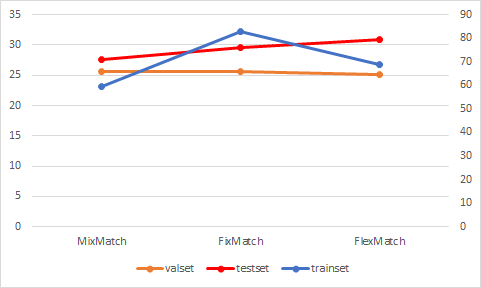

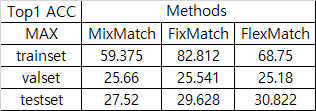

학습과 관련하여 최대한 비슷하게 실험을 진행해서, 각 방법론 별 Top 1 분류 정확도를 비교해본 결과입니다.

testset (빨간선)에 대해서 초반의 예상처럼 MixMatch < FixMatch < FlexMatch 의 형태로 분류 정확도 값이 나왔습니다.

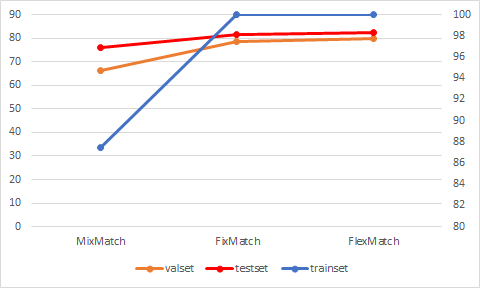

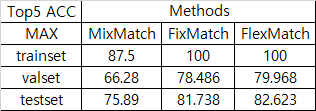

이어서 각 방법론 별 Top 5 분류 정확도를 비교해본 결과입니다.

여기서도 마찬가지로 testset (빨간선)에 대해서 초반의 예상처럼 MixMatch < FixMatch < FlexMatch 의 형태로 분류 정확도 값이 나왔습니다.

# EOD